In [2022]:
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


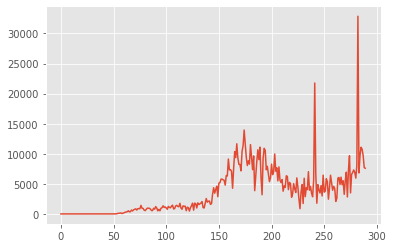

In [2023]:
import pandas as pd
import numpy as np
DATA_URI = "https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Cases.csv"

df = pd.read_csv(DATA_URI)

DATA_URI = "https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Deaths.csv"


df_deaths = pd.read_csv(DATA_URI)


cases=df[df.location_name=="Texas"]
deaths=df_deaths[df_deaths.location_name=="Texas"]
joined_df_full = cases.set_index('date').join(deaths.set_index('date'),how='left',lsuffix='cases',rsuffix='deaths')
joined_df = joined_df_full.loc[joined_df_full.index <= '2020-11-08']
plt.plot(joined_df.valuecases.values)

[   0    0    0    0    0    0    0    0   10   44  132  162  229  209
  224  204  272  197  183  176  195  234  288  430  766  989 1189 1799
 1591 1262 1280 1021  886  759  657  663  572  638  514  508  579  695]


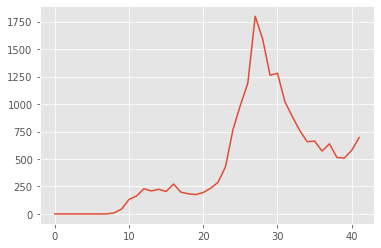

In [2024]:
ohlc_dict = {
'locationcases':'first',
'location_namecases':'first',
'valuecases':'sum',
'locationdeaths':'first',
'location_namedeaths':'first',
'valuedeaths':'sum'}
joined_df.index = pd.to_datetime(joined_df.index)
df_resampled = joined_df.resample('W-Sun').agg(ohlc_dict)
joined_df = df_resampled
print (df_resampled.valuedeaths.values)
plt.plot(df_resampled.valuedeaths.values)

In [2025]:
import rpy2
import numpy as np
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
splines = importr("splines")
predict = importr("stats")


df_full = pd.DataFrame({'X':np.arange(len(joined_df.valuecases.tolist())),
                   'Y':np.array(joined_df.valuecases.tolist()),  # add your data here
                    'D': np.array(joined_df.valuedeaths.tolist())})
                  
df_train =df_full
basis = splines.ns(np.arange(0,len(df_full.X.values)),knots=np.arange(0,len(df_full.X.values),3))
basis_matrix = np.array(basis)
basis_train= basis_matrix[:len(df_full.X.values),:]

basis_oos = predict.predict(basis,newx=np.arange(len(df_full.X.values)+1,(len(df_full.X.values)+5)))
basis_oos_matrix = np.array(basis_oos)
num_data =basis_matrix.shape[0]
num_basis = basis_matrix.shape[1]
print (basis_oos_matrix.shape)

(4, 15)


In [2026]:
def ExponentialRandomWalk(loc=1., scale=1e-2, drift=0., num_steps=100):
    '''
    Return distrubtion of exponentiated Gaussian random walk
    
    Variables are x_0, ..., x_{T-1}
    
    Dynamics in log-space are random walk with drift:
       log(x_0) := log(loc) 
       log(x_t) := log(x_{t-1}) + drift + eps_t,    eps_t ~ N(0, scale)
        
    ==> Dynamics in non-log space are:
        x_0 := loc
        x_t := x_{t-1} * exp(drift + eps_t),    eps_t ~ N(0, scale)        
    '''
    
    log_loc = np.log(loc) + drift * (np.arange(num_steps)+0.)
    
    return dist.TransformedDistribution(
        dist.GaussianRandomWalk(scale=scale, num_steps=num_steps),
        [
            dist.transforms.AffineTransform(loc = log_loc, scale=1.),
            dist.transforms.ExpTransform()
        ]
    )

In [2057]:
import jax
def model(B_local=None,Forecast=False):
   
    #a_raw =numpyro.sample('a_raw',dist.Normal(jnp.zeros(num_basis),1000*jnp.ones(num_basis)))
    a_raw = numpyro.sample('a_raw_init',ExponentialRandomWalk(scale=100, num_steps=num_basis))

#    a_raw_boundary = numpyro.sample('a_raw_boundary',ExponentialRandomWalk(loc=tmp,scale=1e-2, num_steps=4)) 
    
    #a_raw =  numpyro.deterministic('a_raw', jnp.concatenate((a_raw_init,a_raw_boundary)))

    tau = numpyro.sample('tau',dist.Exponential(.0000001))
    sigma0 = numpyro.sample('sigma0',dist.Exponential(10000))
    
    
    y_hat =  numpyro.deterministic('y_hat', jnp.dot(jnp.array(B_local), tau*a_raw))
   

    numpyro.sample('c_obs', dist.Normal(y_hat, sigma0), obs=df_train.Y.values)
    


    #numpyro.sample('d',dist.Normal(d_hat,10),obs=df_train.D)

In [2058]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 100, 200
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_,B_local=basis_train)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 300/300 [00:13<00:00, 22.66it/s, 7 steps of size 4.32e-04. acc. prob=0.94] 



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 a_raw_init[0]      2.03      0.03      2.04      2.00      2.06      2.45      7.79
 a_raw_init[1]      0.31      0.00      0.31      0.30      0.31      2.44      6.63
 a_raw_init[2]      0.12      0.00      0.12      0.12      0.12      3.92      2.15
 a_raw_init[3]      0.99      0.00      0.99      0.99      1.00      2.45      7.30
 a_raw_init[4]      0.32      0.00      0.33      0.32      0.33      2.51      9.02
 a_raw_init[5]      2.69      0.30      2.86      2.37      3.02      2.47      8.63
 a_raw_init[6]      0.19      0.00      0.19      0.19      0.19      2.49      7.64
 a_raw_init[7]      0.32      0.01      0.31      0.31      0.34      2.46      7.64
 a_raw_init[8]      0.56      0.06      0.53      0.50      0.63      2.46      7.83
 a_raw_init[9]      1.38      0.36      1.12      0.99      1.80      2.46      6.99
a_raw_init[10]      2.71      0.37      2.90      2.31      3.13

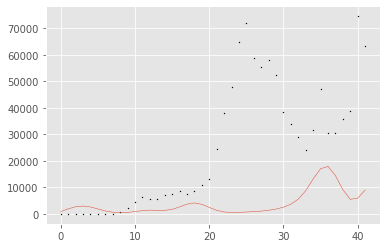

In [2056]:
plt.style.use('ggplot')

plt.plot(df_train.X.values,samples_1['y_hat'].mean(axis=0),linewidth=.5)
plt.scatter(df_train.X.values,df_train.Y.values,color='black',s=.75)

In [2039]:
def model2(lagged_mat=None ,Forecast=False,b_2_tmp=None,B_local=None,beta_mult=1):
    b_1 = numpyro.sample('slope',dist.Normal(jnp.zeros(3),1000*jnp.ones(3)))
    #w_1 = numpyro.sample('w',dist.Beta(100,1))
    a_raw = numpyro.sample('a_raw_init',ExponentialRandomWalk(scale=1e-1, num_steps=num_basis))

#    a_raw_boundary = numpyro.sample('a_raw_boundary',ExponentialRandomWalk(loc=tmp,scale=1e-2, num_steps=4)) 
    
    #a_raw =  numpyro.deterministic('a_raw', jnp.concatenate((a_raw_init,a_raw_boundary)))

    tau = numpyro.sample('tau',dist.Exponential(1000))
    
    #jnp.dot(jnp.array(B_local), tau*a_raw) 
    y_hat =  numpyro.deterministic('d_hat',   jnp.dot(beta_mult*b_1,lagged_mat) + jnp.dot(jnp.array(B_local), tau*a_raw) )
   

    numpyro.sample('c_obs', dist.Normal(y_hat, 10), obs=df_train.D.values[3:])
    


In [2040]:
lagged_mat = jnp.transpose(np.matrix(lagged_Y.values))
lagged_mat = pd.concat([df_full.Y.shift(1),df_full.Y.shift(2),df_full.Y.shift(3)],axis=1).dropna()
normalization_constant = np.max(lagged_mat.values)
lagged_mat = lagged_mat/normalization_constant
print (lagged_mat.shape)
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 100, 200
# Run NUTS.
kernel = NUTS(model2)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_,lagged_mat=np.transpose(lagged_mat.values),B_local=basis_train[3:,:],beta_mult=1)
mcmc.print_summary()
samples_2 = mcmc.get_samples()

(39, 3)


sample: 100%|██████████| 300/300 [00:09<00:00, 32.70it/s, 63 steps of size 2.76e-02. acc. prob=0.93] 



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 a_raw_init[0]      1.00      0.10      1.00      0.83      1.15    113.30      1.00
 a_raw_init[1]      1.00      0.13      0.99      0.79      1.21     62.63      1.00
 a_raw_init[2]      1.00      0.16      1.00      0.75      1.24     50.89      1.00
 a_raw_init[3]      1.01      0.19      0.99      0.67      1.27     42.04      1.00
 a_raw_init[4]      1.00      0.21      0.99      0.60      1.32     34.80      0.99
 a_raw_init[5]      0.99      0.23      0.98      0.65      1.38     34.11      1.00
 a_raw_init[6]      0.98      0.24      0.96      0.58      1.34     33.39      1.00
 a_raw_init[7]      1.00      0.26      0.97      0.60      1.41     35.22      0.99
 a_raw_init[8]      1.01      0.28      0.99      0.59      1.47     35.21      0.99
 a_raw_init[9]      1.01      0.29      1.01      0.49      1.39     29.51      1.00
a_raw_init[10]      1.01      0.31      1.02      0.47      1.39

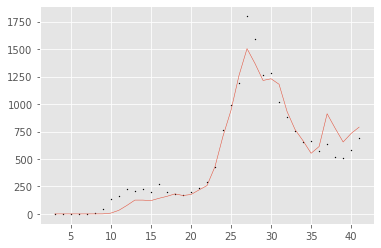

In [2041]:
plt.style.use('ggplot')
plt.plot(df_train.X.values[3:],samples_2['d_hat'].mean(axis=[0]),linewidth=.5)
plt.scatter(df_train.X.values[3:],df_train.D.values[3:],color='black',s=.75)

In [2042]:
from numpyro.infer import Predictive
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_,B_local=basis_oos_matrix,Forecast=True)['y_hat']


In [2043]:
yhat_forecast = pd.Series(np.concatenate((samples_1['y_hat'].mean(axis=0),predictions.mean(axis=0))))

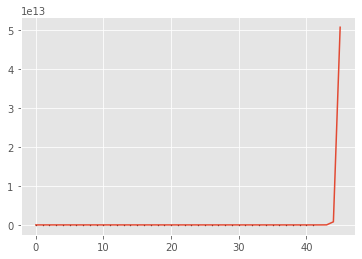

In [2044]:
plt.plot(np.exp(yhat_forecast))
plt.scatter(df_train.X.values,df_train.Y.values,color='black',s=.75)

In [2045]:
lagged_y_forecasts = pd.concat([yhat_forecast.shift(1),yhat_forecast.shift(2),yhat_forecast.shift(3)],axis=1).dropna()
lagged_y_forecasts = lagged_y_forecasts.values[-4:,:]
normalized= np.transpose(lagged_y_forecasts)/normalization_constant
print (normalized)
predictive = Predictive(model2, samples_2)
predictions = predictive(rng_key_,
                         lagged_mat=normalized,
                        Forecast=True,B_local=basis_oos_matrix,beta_mult=1)['d_hat']



[[1.4445171e-04 2.5590166e-04 3.1162667e-04 3.6735166e-04]
 [9.2864240e-05 1.4445171e-04 2.5590166e-04 3.1162667e-04]
 [6.6101878e-05 9.2864240e-05 1.4445171e-04 2.5590166e-04]]


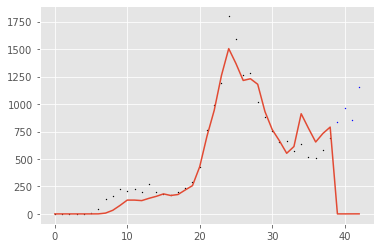

In [2046]:
joined_df_test = joined_df_full.loc[(joined_df_full.index <= "2020-12-05")&(joined_df_full.index >= "2020-11-09")]
joined_df_test.index = pd.to_datetime(joined_df_test.index)
df_resampled_test = joined_df_test.resample('W-Sun',label='left').agg(ohlc_dict)

plt.plot(np.concatenate((samples_2['d_hat'].mean(axis=[0]),predictions.mean(axis=0))))
plt.scatter(np.arange(len(df_train.D.values[3:])),df_train.D.values[3:],color='black',s=.75)
plt.scatter(np.arange(len(df_train.D.values[3:]),len(df_train.D.values[3:])+4),df_resampled_test.valuedeaths.values,color='blue',s=.8)


In [2038]:
np.arange(len(df_train.D.values[3:])+1,len(df_train.D.values[3:])+4)

array([40, 41, 42])